<a href="https://colab.research.google.com/github/Carsoboss/pytorch_fundamentals/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can e multiple things as options).

## 1. Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                   noise = 0.03,
                   random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [ ]:
# Make DataFram of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


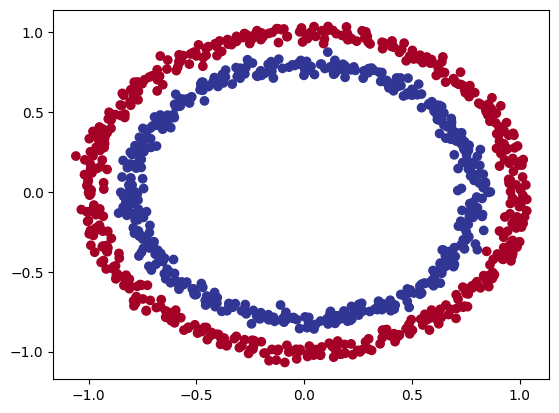

In [ ]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experimetn but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f" Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
 Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [ ]:
import torch
torch.__version__

'2.2.1+cu121'

In [ ]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, #0.2 = 20% of data will be test and 80% will be train
                                                    random_state=42)

In [ ]:
print(f"Length of X_train: {len(X_train)}"),
print(f"Length of X_test: {len(X_test)}"),
print(f"Length of y_train: {len(y_train)}"),
print(f"Length of y_test: {len(X_test)}")

Length of X_train: 800
Length of X_test: 200
Length of y_train: 800
Length of y_test: 200


In [ ]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2.  Construct a model (by subclassing 'nn.module')
3.  Define a loss function and optimizer
4.  Create a training and test loop

In [ ]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
X_train.shape

torch.Size([800, 2])

Now we've setup device agnostic code, let's create a model that:

1.  Subclass 'nn.Module' (almost all models in PyTorch subcclass 'nn.Module')
2.  Create 2 'nn.Linear()' layers that are capable of handling the shapes of our data
3.  Defines a 'forward()' method that outlines the forward pass (or forward computation) of the model
4.  Instantiate an instance of our model class and send it to the target 'device'

In [ ]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [ ]:
import sklearn
# 1.  Construct a model that subclasses nn.module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2.  Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # Takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # Takes in 5 features from previous layer and downsclaes to 1 feature (same shape as y)
  #3.  Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

#4.  Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cpu'

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

In [ ]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1780, -0.6350],
                      [ 0.2364,  0.0054],
                      [ 0.6590, -0.2538],
                      [-0.0578, -0.6053],
                      [ 0.4077,  0.2573]])),
             ('0.bias', tensor([ 0.3579, -0.0552,  0.4981, -0.5121,  0.4318])),
             ('1.weight',
              tensor([[-0.3621,  0.2699, -0.0941, -0.1622,  0.4025]])),
             ('1.bias', tensor([0.1443]))])

In [ ]:
# Make predicitons
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
untrained_preds = model_0(X_test.to(device))
print(f"Length of predicitons: {len(untrained_preds)}), Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predicitons: 200), Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[0.],
        [1.],
        [-0.],
        [1.],
        [-0.],
        [0.],
        [1.],
        [0.],
        [-0.],
        [1.]], grad_fn=<RoundBackward0>)

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again ... this is problem specific.

For example for regression you might want MAE or MSE (Mean absolute error or mean squared error).

For classification you might want binary cross entropy or catergorical cross entropy (cross entropy).

As a reminder, the loss funciton measures how *wrong* your model predicitons are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For some comon choices for loss functions and optimizers checkout the lossfunction and optimizer

* For the loss function we're going to use 'torch.nn.BCEWithLogitsLoss()', for more on what binary cross entropy (BCE) is look it up.

* For different optimizers see 'torch.optim'






In [ ]:
# Setup the loss function
# loss_fn == nn.BCELoss() #BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation funciton built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

To train our mode, we're going to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient desent)

### 3.1 Going from raw logits ->. prediciton probabilities -> prediciton labels

Our model outputs are going to be raw **logits**

We can gonvert these **logits** into prediciton probablitlites by passing them to some kind of activation function (e.g. sigmoid for binary classifiation and softmax for multiclass classificaiton).

Then we can convert our model's prediciton probabilities to **prediciton labels** by either rounding them or taking the **argmax()**

In [ ]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.4802],
        [ 0.6502],
        [-0.0119],
        [ 0.6198],
        [-0.0855]])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Use the sigmoid activation function on our model logits to turn them into prediciton probs
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6178],
        [0.6571],
        [0.4970],
        [0.6502],
        [0.4786]])

For our prediciton probablility values, we need to perform a range-style rounding on them:
* 'y_pred_probs' >= 0.5, 'y=1' (class 1)
* 'y_pred_probs' < 0.5, 'y=0' (class 0)

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 0., 1., 0.])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## 3.2 Building a training and test loop

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70658, Accuracy: 53.00% | Test loss: 0.72242, Test acc: 49.00%
Epoch: 10 | Loss: 0.70580, Accuracy: 52.62% | Test loss: 0.72133, Test acc: 49.00%
Epoch: 20 | Loss: 0.70509, Accuracy: 52.38% | Test loss: 0.72032, Test acc: 48.50%
Epoch: 30 | Loss: 0.70445, Accuracy: 52.50% | Test loss: 0.71938, Test acc: 48.50%
Epoch: 40 | Loss: 0.70385, Accuracy: 52.50% | Test loss: 0.71852, Test acc: 49.00%
Epoch: 50 | Loss: 0.70331, Accuracy: 52.38% | Test loss: 0.71771, Test acc: 49.00%
Epoch: 60 | Loss: 0.70281, Accuracy: 52.38% | Test loss: 0.71695, Test acc: 49.00%
Epoch: 70 | Loss: 0.70235, Accuracy: 52.75% | Test loss: 0.71625, Test acc: 49.00%
Epoch: 80 | Loss: 0.70192, Accuracy: 52.88% | Test loss: 0.71559, Test acc: 49.00%
Epoch: 90 | Loss: 0.70153, Accuracy: 52.25% | Test loss: 0.71497, Test acc: 48.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything ...

So to inspect it let's make some predictions and make them visual!

To do so import a function called 'plot_decision_boundry'



In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


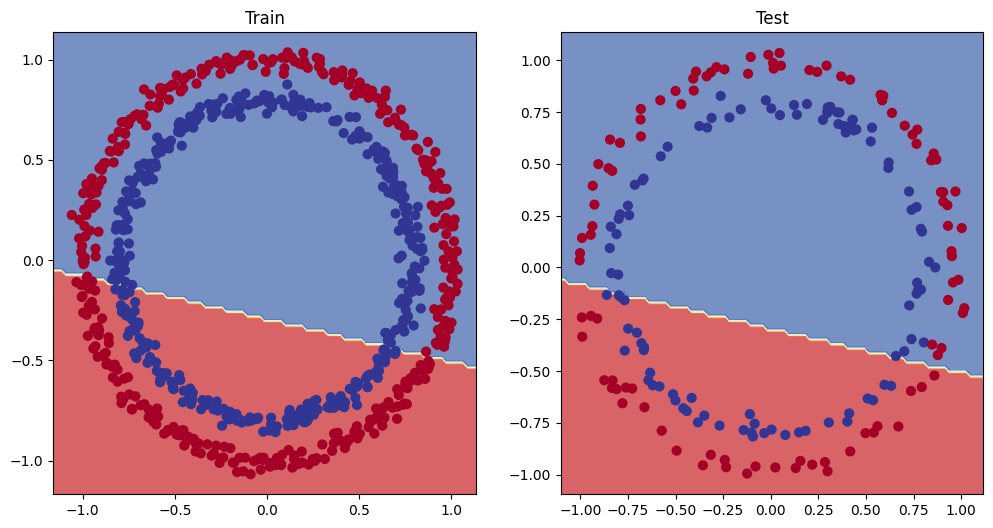

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model mroe chances to learn about patterns in the data
* Add more hidden units -go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function
These options are all from a model's perspective beacause they deal directly with the model, rather than the data.
And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as **hyperparameters**

Let's try and improve our model by:
* Adding more hidden units:
* Increase the number of layers:
* Increase the number of epochs:

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer

optimizer = torch.optim.SGD(params= model_1.parameters(),
                            lr=.1)

In [ ]:
# Write a training an evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
x_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

  # 2. Calculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
               y_pred=y_pred)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backprop)
  loss.backward()

  # 5. Optimizer step (grad descent)

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    tst_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happenin
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} |Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss: .5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 |Loss: 0.69396, Acc: 50.88% | Test loss:  0.69261, Test acc: 47.50%
Epoch: 100 |Loss: 0.69396, Acc: 50.88% | Test loss:  0.69261, Test acc: 47.50%
Epoch: 200 |Loss: 0.69396, Acc: 50.88% | Test loss:  0.69261, Test acc: 47.50%
Epoch: 300 |Loss: 0.69396, Acc: 50.88% | Test loss:  0.69261, Test acc: 47.50%
Epoch: 400 |Loss: 0.69396, Acc: 50.88% | Test loss:  0.69261, Test acc: 47.50%
Epoch: 500 |Loss: 0.69396, Acc: 50.88% | Test loss:  0.69261, Test acc: 47.50%
Epoch: 600 |Loss: 0.69396, Acc: 50.88% | Test loss:  0.69261, Test acc: 47.50%
Epoch: 700 |Loss: 0.69396, Acc: 50.88% | Test loss:  0.69261, Test acc: 47.50%
Epoch: 800 |Loss: 0.69396, Acc: 50.88% | Test loss:  0.69261, Test acc: 47.50%
Epoch: 900 |Loss: 0.69396, Acc: 50.88% | Test loss:  0.69261, Test acc: 47.50%


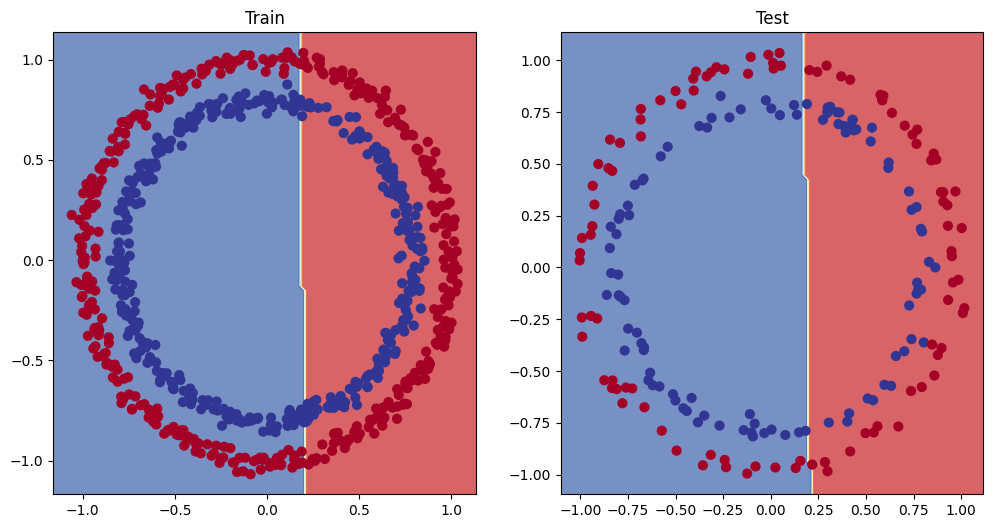

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem.  

In [ ]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)


(80, 20, 80, 20)

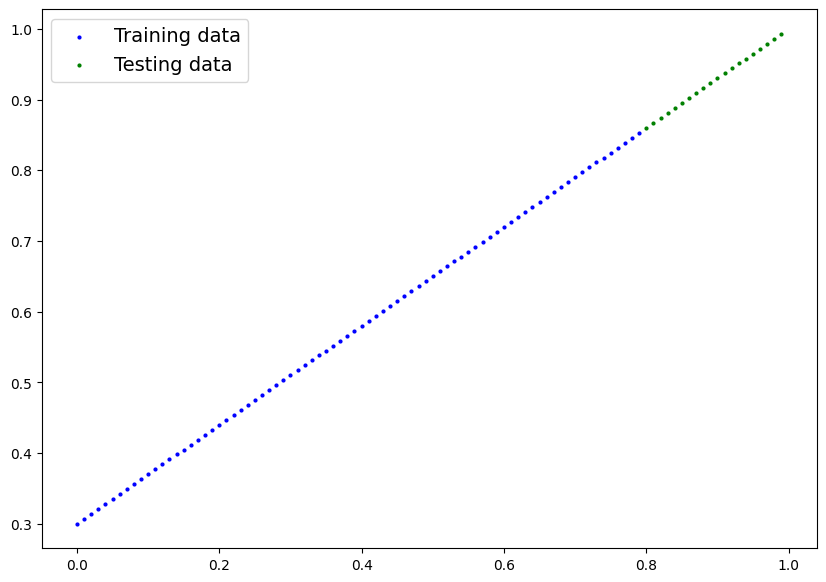

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                test_data=X_test_regression,
                test_labels=y_test_regression);

In [ ]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

### 5.2 Adjusting 'model_1' to fit a straight line

In [ ]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=16),
    nn.Linear(in_features=16, out_features=8),
    nn.Linear(in_features=8, out_features=1)
)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Linear(in_features=16, out_features=8, bias=True)
  (2): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
device

'cpu'

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [ ]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 1.02780, Test loss: 1.35643
Epoch: 100 | Train loss: 0.05812, Test loss: 0.00505
Epoch: 200 | Train loss: 0.05404, Test loss: 0.00751
Epoch: 300 | Train loss: 0.04571, Test loss: 0.00400
Epoch: 400 | Train loss: 0.04397, Test loss: 0.00754
Epoch: 500 | Train loss: 0.03663, Test loss: 0.00554
Epoch: 600 | Train loss: 0.03994, Test loss: 0.00826
Epoch: 700 | Train loss: 0.03606, Test loss: 0.00471
Epoch: 800 | Train loss: 0.03507, Test loss: 0.00454
Epoch: 900 | Train loss: 0.03545, Test loss: 0.00597


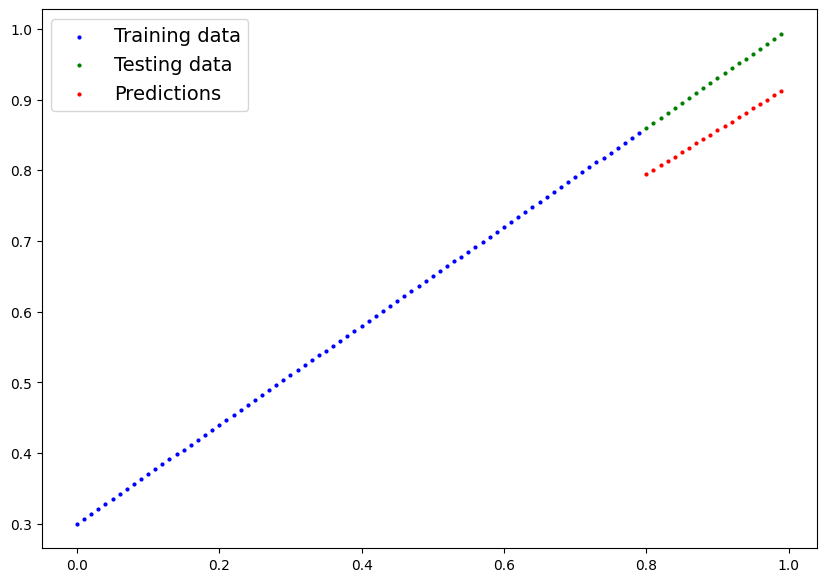

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?



### 6.1 Recreating non-linear data (red and blue circles)

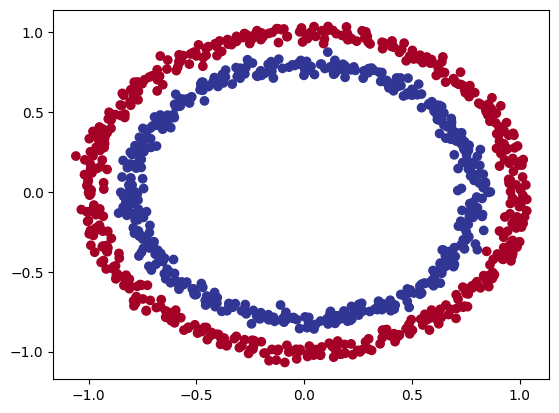

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                   noise= 0.03,
                   random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [ ]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [ ]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=8)
        self.layer_4 = nn.Linear(in_features=8, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=8, bias=True)
  (layer_4): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
## Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity

In [ ]:
# Fit the model
torch.manual_seed(42)
epochs = 1800

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6949, Acc: 50.00% | Test Loss: 0.6944, Test Acc: 50.00%
Epoch: 100 | Loss: 0.6926, Acc: 53.00% | Test Loss: 0.6921, Test Acc: 54.50%
Epoch: 200 | Loss: 0.6920, Acc: 52.00% | Test Loss: 0.6914, Test Acc: 57.00%
Epoch: 300 | Loss: 0.6913, Acc: 52.62% | Test Loss: 0.6906, Test Acc: 58.00%
Epoch: 400 | Loss: 0.6903, Acc: 54.00% | Test Loss: 0.6895, Test Acc: 58.00%
Epoch: 500 | Loss: 0.6888, Acc: 55.50% | Test Loss: 0.6879, Test Acc: 58.00%
Epoch: 600 | Loss: 0.6867, Acc: 56.00% | Test Loss: 0.6857, Test Acc: 59.00%
Epoch: 700 | Loss: 0.6832, Acc: 56.88% | Test Loss: 0.6821, Test Acc: 59.00%
Epoch: 800 | Loss: 0.6760, Acc: 58.13% | Test Loss: 0.6755, Test Acc: 58.50%
Epoch: 900 | Loss: 0.6613, Acc: 62.75% | Test Loss: 0.6629, Test Acc: 62.50%
Epoch: 1000 | Loss: 0.6198, Acc: 80.12% | Test Loss: 0.6304, Test Acc: 76.50%
Epoch: 1100 | Loss: 0.4583, Acc: 99.25% | Test Loss: 0.4925, Test Acc: 96.00%
Epoch: 1200 | Loss: 0.4540, Acc: 72.38% | Test Loss: 0.5265, Test Acc: 56.50

In [ ]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.9431,  0.4387],
                      [-0.2994,  2.1915],
                      [-0.1549,  0.1427],
                      [-0.5512,  0.0258],
                      [ 0.7410, -0.8119],
                      [ 0.9678,  0.1979],
                      [ 1.0633,  0.3944],
                      [ 0.7984, -0.1238],
                      [ 0.8773,  0.9567],
                      [-1.1013,  0.7393],
                      [-0.5556, -0.1555],
                      [-0.2967,  0.4173],
                      [-0.6168, -0.4527],
                      [-0.8682, -1.4804],
                      [ 0.1488, -0.9159],
                      [ 1.4406, -1.2065]])),
             ('layer_1.bias',
              tensor([ 1.0578, -0.1203, -0.2296,  0.5387, -0.0549,  0.9952, -0.4352, -0.2709,
                      -0.4696, -0.4220,  0.5611,  0.5642,  0.7518, -0.1274, -0.2884, -0.2267])),
             ('layer_2.weight',
              tensor([[ 6.7052e-02, -1.5

### 6.4 Evaluating a model trained with non-linear activation functions

In [ ]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

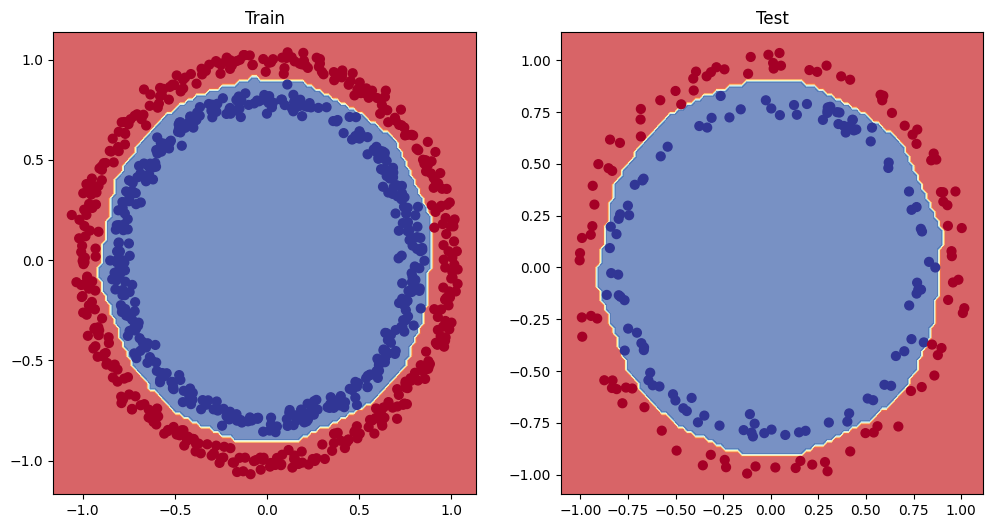

In [ ]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) # model_1 is only linear
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 has linear and non-linear

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

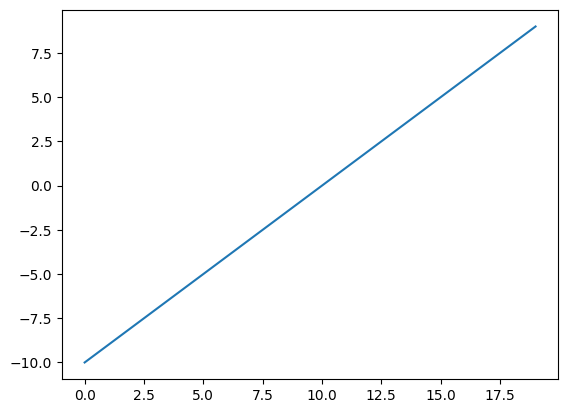

In [ ]:
# Visualize the tensor
plt.plot(A);

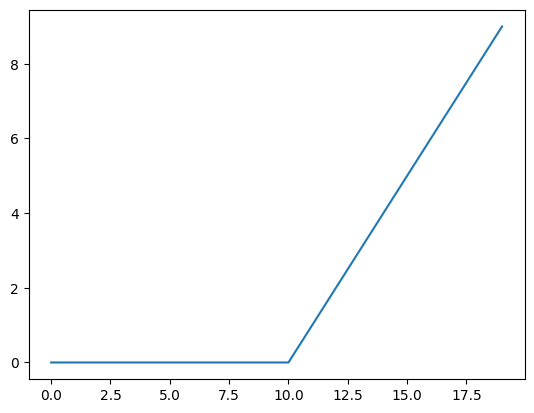

In [ ]:
plt.plot(torch.relu(A));

In [ ]:
def relu(x: torch.Tensor):
  return torch.maximum(torch.tensor(0), x) #inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

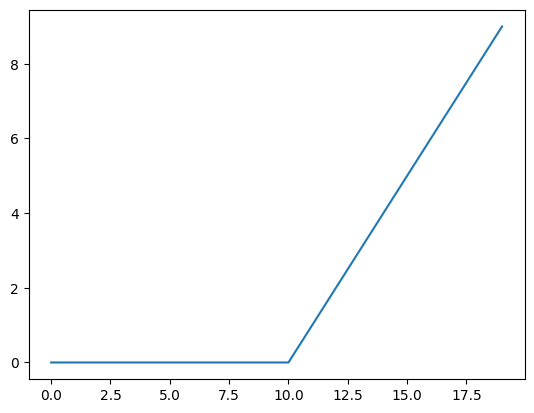

In [ ]:
# Plot ReLU activation function
plt.plot(relu(A));

In [ ]:
# Now let's do sigmoid
def sigmoid(x):
  return 1/ (1+torch.exp(-x))

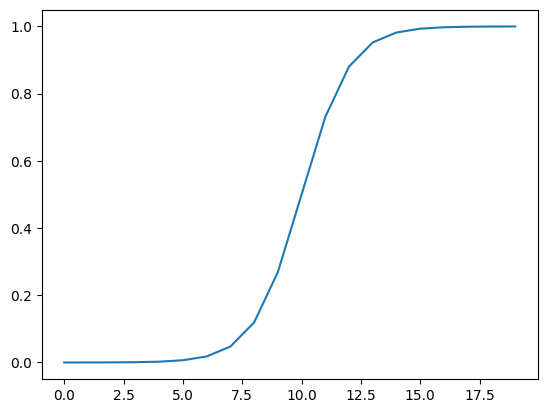

In [ ]:
plt.plot(torch.sigmoid(A));

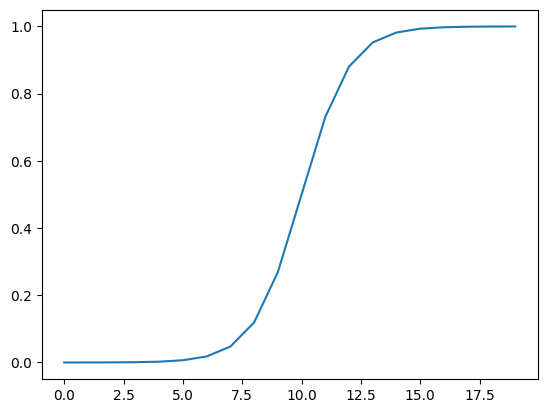

In [ ]:
plt.plot(sigmoid(A));

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam)
* Multi-classification = more than one thing or another (cat vs. dog vs. chicken)

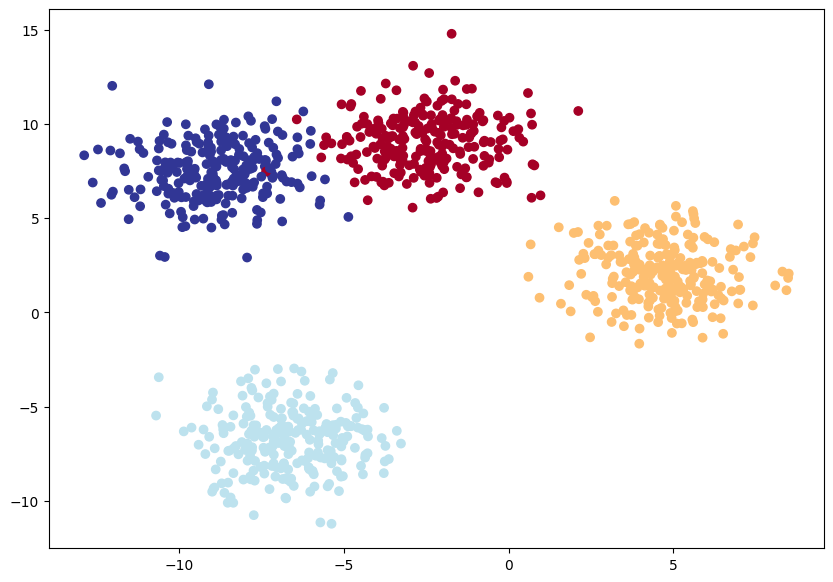

In [ ]:
# Import dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Creat multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test, = train_test_split(X_blob,
                                                                       y_blob,
                                                                       test_size=0.2,
                                                                       random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);


### 8.2 Building a multi-class classification model in PyTorch

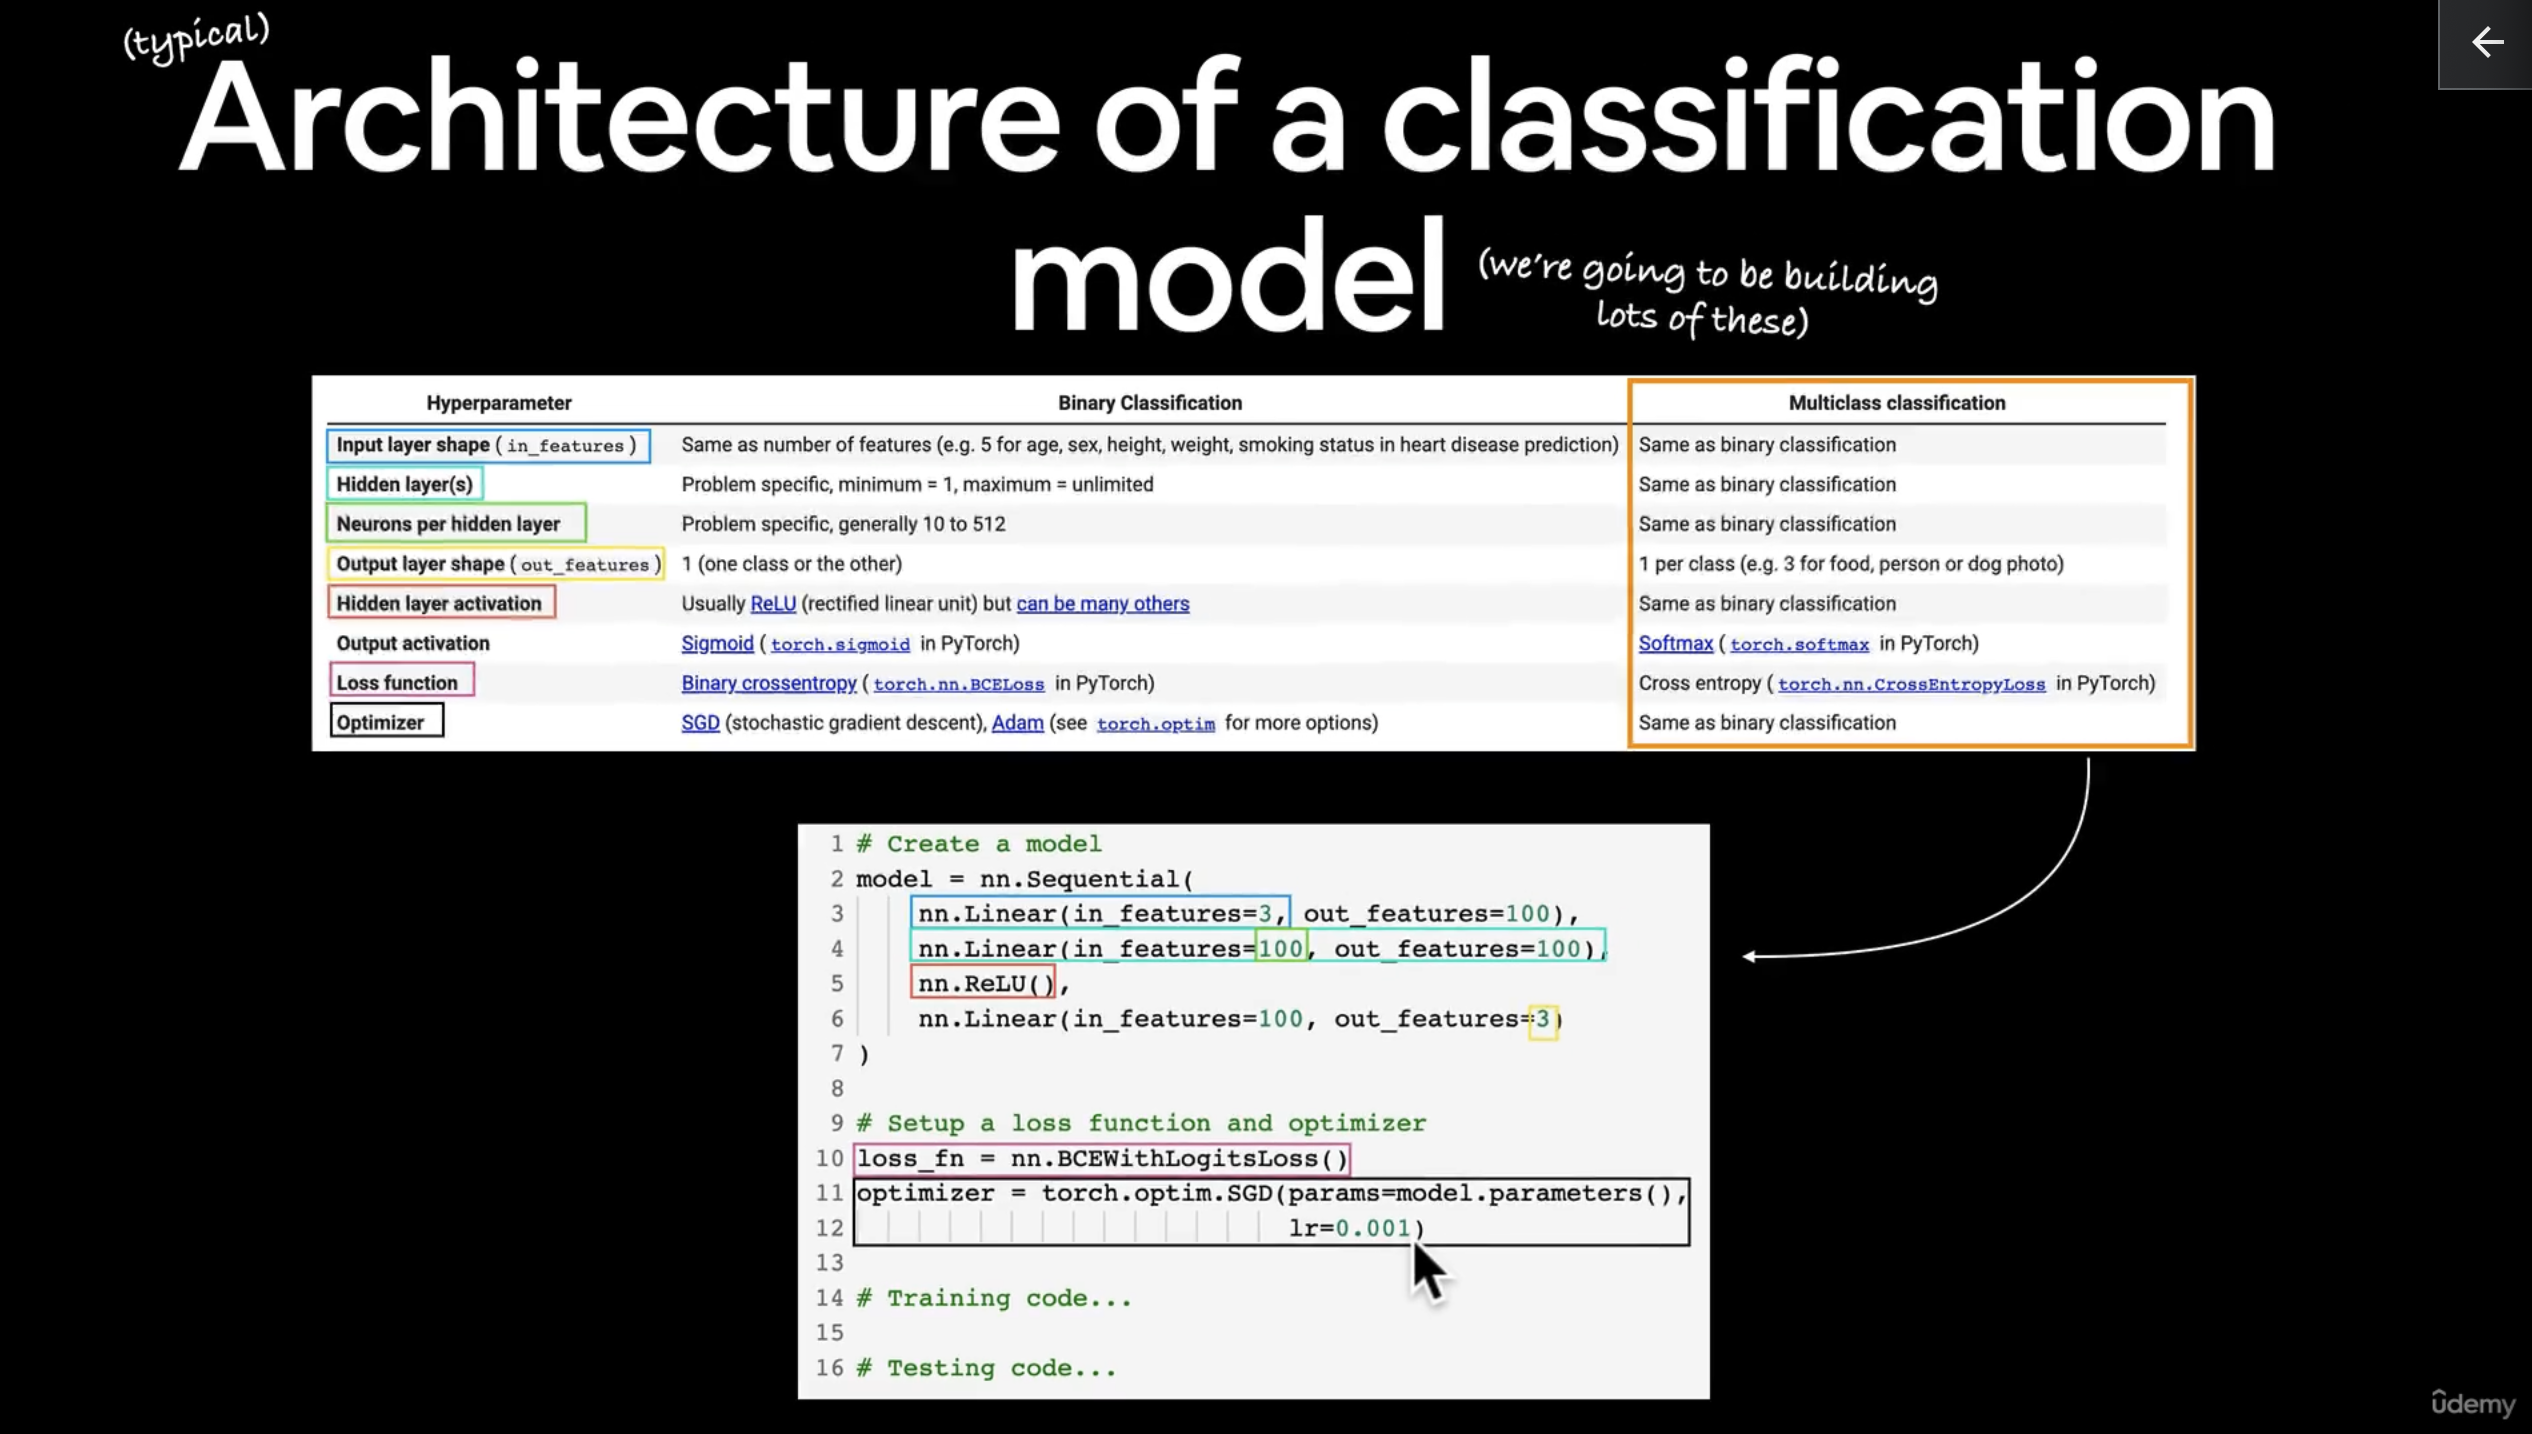

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [ ]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [ ]:
# Create a loss funciton for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classificaiton - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1) # learning rate is a hyperparamter you can change

### 8.4 Getting prediciton probabilities

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probailities and then prediction labels
Logits (raw output of the model) -> Pred probs(use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [ ]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
y_logits = model_4(X_blob_train.to(device))

y_logits[:10]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923],
        [-0.2044, -1.1380, -0.9468, -0.3093],
        [-0.2613, -1.2852, -1.0251, -0.2935],
        [-0.5237, -0.5791, -1.1276, -0.8689],
        [-0.0423, -0.8228, -0.4666, -0.0986],
        [-0.1876, -1.1245, -0.8498, -0.2406]], grad_fn=<SliceBackward0>)

In [ ]:
# Convert our model's logit outputs to prediciton probailities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], grad_fn=<SliceBackward0>)
tensor([[0.3080, 0.3328, 0.1441, 0.2150],
        [0.3577, 0.1324, 0.1696, 0.3402],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3000, 0.1845, 0.2743, 0.2413],
        [0.3424, 0.1450, 0.1936, 0.3190]], grad_fn=<SliceBackward0>)


In [ ]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [ ]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [ ]:
torch.argmax(y_pred_probs[0])

tensor(1)

#### So basically the softmax turns each tensor into a mix of probabilities that all equal one when added together.  The argmax then tells you the index of the highest probability in that tensor

In [ ]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0,
        3, 0, 3, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 3, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: [epoch] | Loss: 1.1588, Acc: 40.38% | Test loss: 0.0263, Test Acc: 48.00%
Epoch: [epoch] | Loss: 0.6448, Acc: 96.75% | Test loss: 0.0263, Test Acc: 97.50%
Epoch: [epoch] | Loss: 0.4254, Acc: 98.50% | Test loss: 0.0263, Test Acc: 100.00%
Epoch: [epoch] | Loss: 0.2529, Acc: 99.12% | Test loss: 0.0263, Test Acc: 99.50%
Epoch: [epoch] | Loss: 0.1123, Acc: 99.25% | Test loss: 0.0263, Test Acc: 99.50%
Epoch: [epoch] | Loss: 0.0663, Acc: 99.25% | Test loss: 0.0263, Test Acc: 99.50%
Epoch: [epoch] | Loss: 0.0507, Acc: 99.25% | Test loss: 0.0263, Test Acc: 99.50%
Epoch: [epoch] | Loss: 0.0430, Acc: 99.25% | Test loss: 0.0263, Test Acc: 99.50%
Epoch: [epoch] | Loss: 0.0384, Acc: 99.25% | Test loss: 0.0263, Test Acc: 99.50%
Epoch: [epoch] | Loss: 0.0352, Acc: 99.25% | Test loss: 0.0263, Test Acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [ ]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


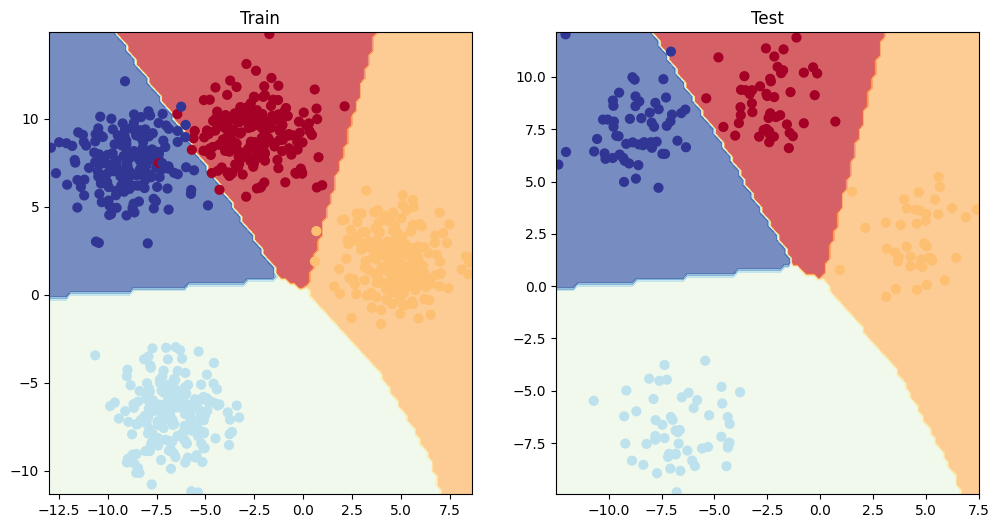

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of n samples how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report (Puts together all of the metrics)

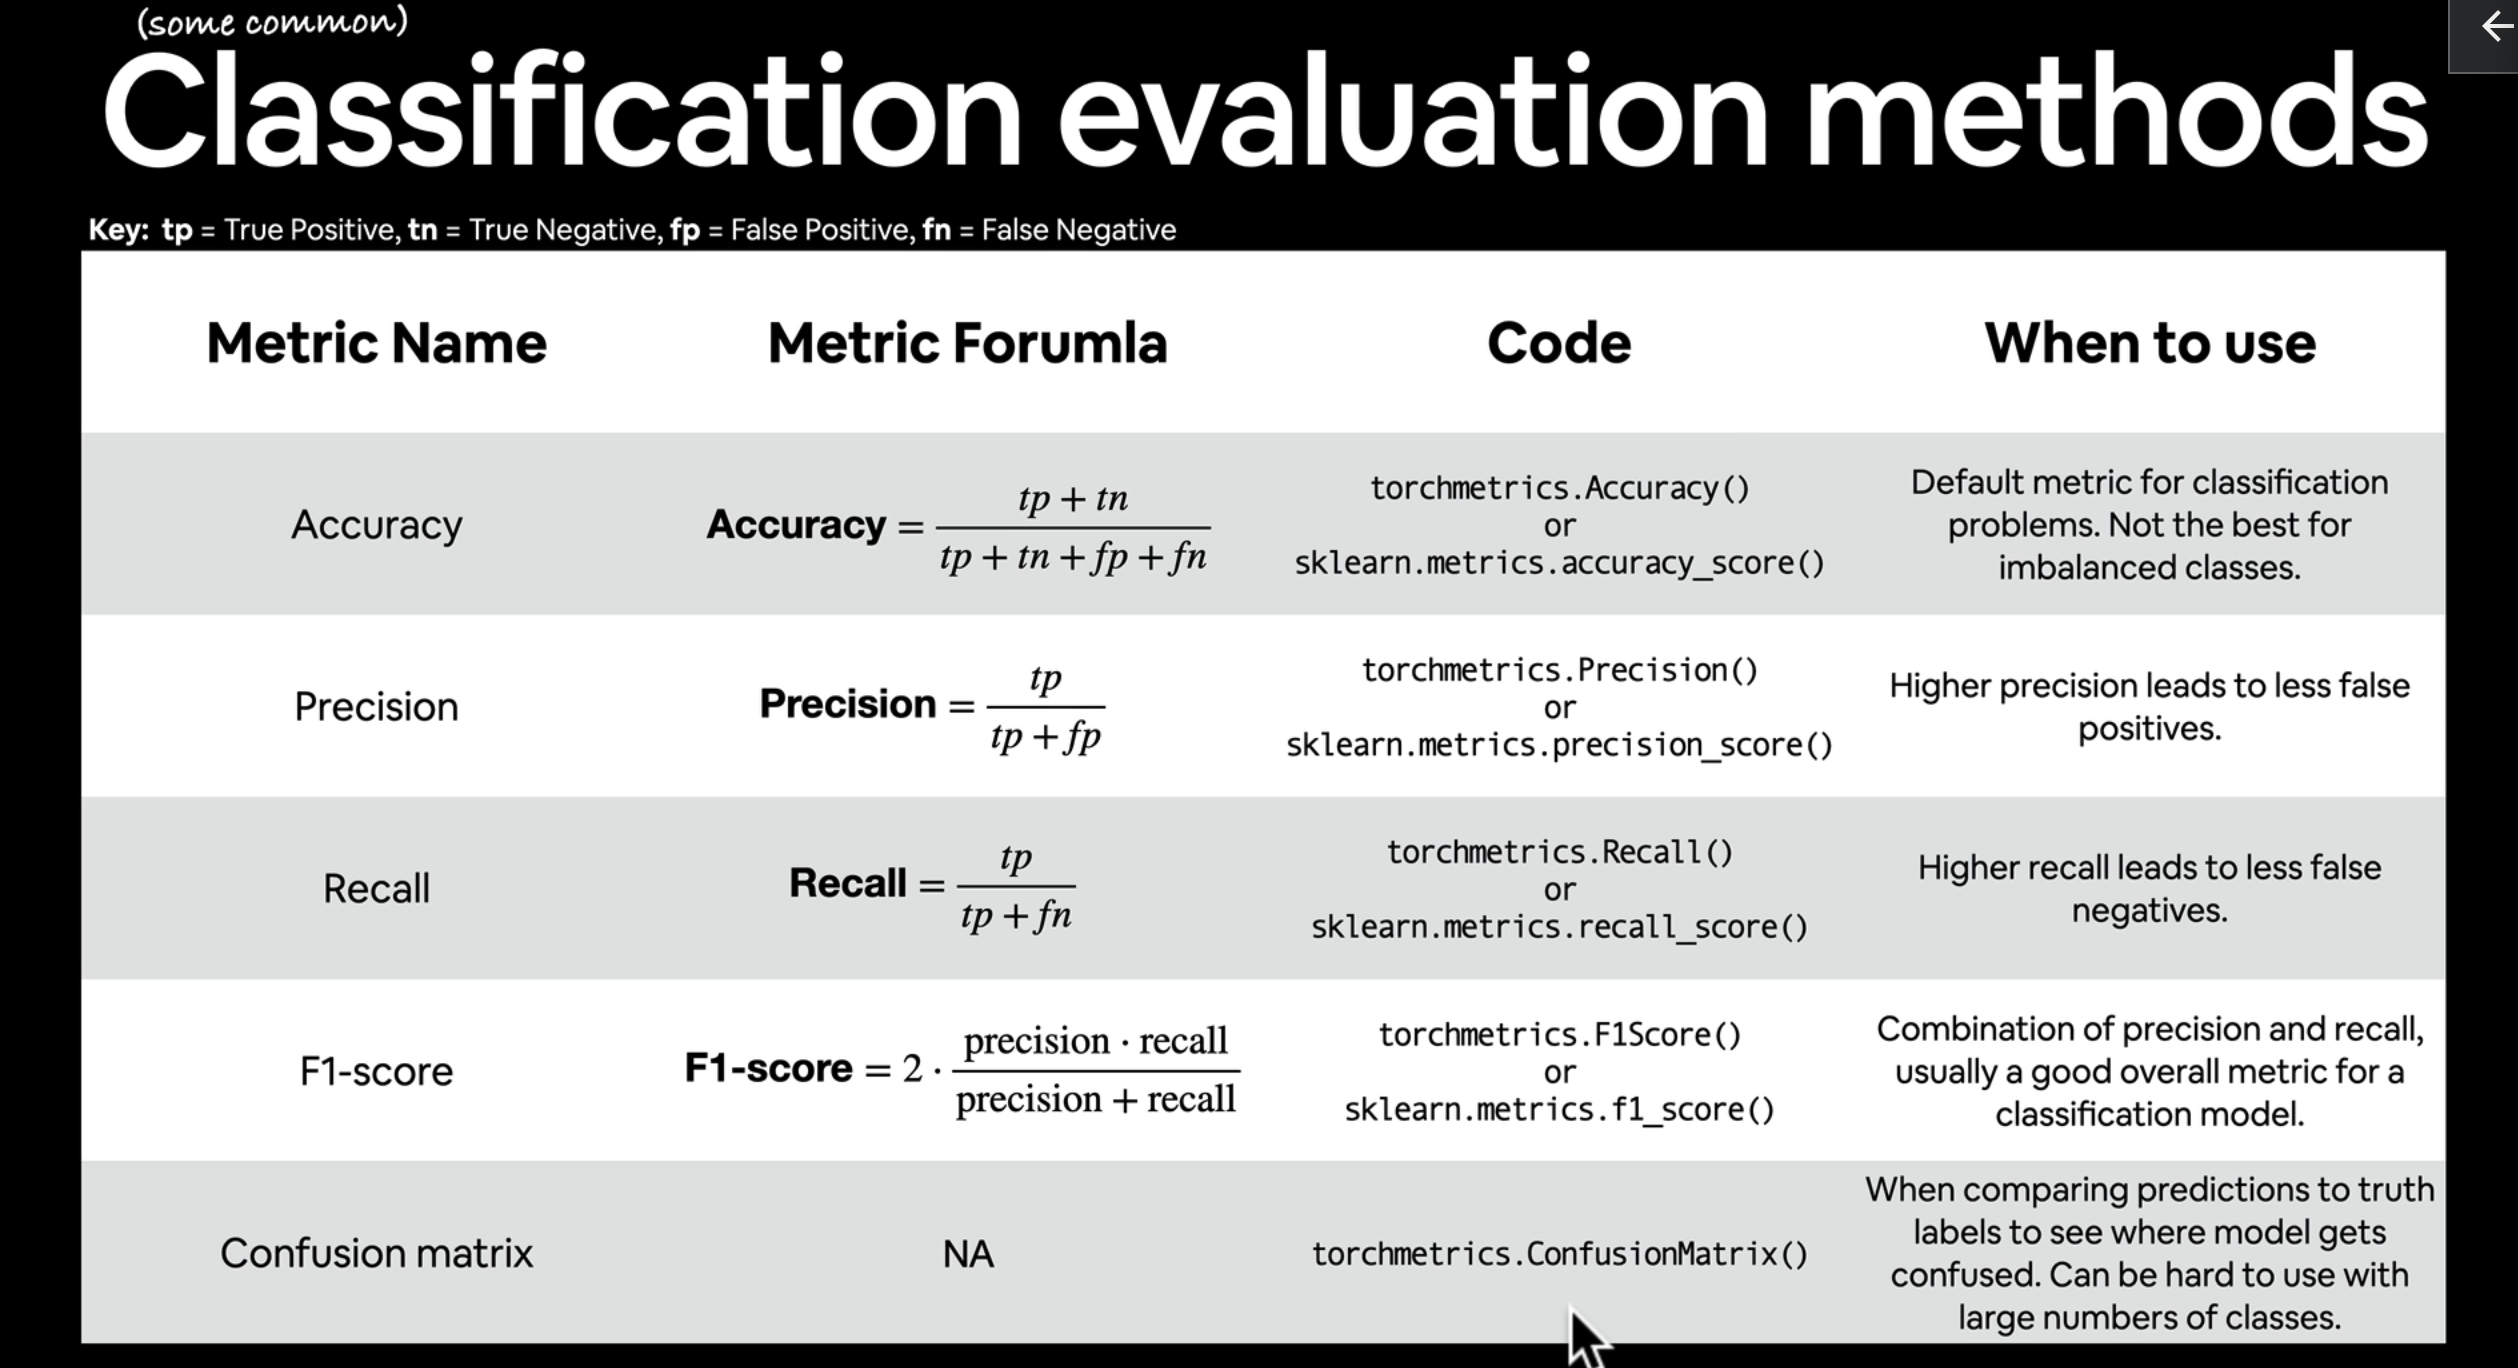

In [86]:
!pip install torchmetrics

In [88]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)